# GR5242 AML Project: VAE for downstream classification

Xixi Chen xc2444, Zhengyuan Dong zd2216

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
from IPython import display

import numpy as np
import tensorflow_probability as tfp
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns


TensorFlow 2.x selected.


## Data Loading And Preprocessing 

The data we used is Fashion-MNIST, which contains 28$\times$28 gray-scale images of clothing from 10 classes. There are in total 60,000 training samples and 10,000 testing samples. 

In [0]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
# Reshape data before using
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.


In [0]:
# Use all samples to train vae
# so combine test and train samples
all_images = np.concatenate((train_images, test_images), axis = 0)

In [0]:

train_buffer = 60000
batch_size = 100
test_buffer = 10000
all_buffer = train_buffer + test_buffer

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_buffer).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_buffer).batch(batch_size)
all_dataset = tf.data.Dataset.from_tensor_slices(all_images).shuffle(all_buffer).batch(batch_size)

## Implement Variational Auto Encoders

### Define VAE (Using convolutional neural networks)

In [0]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
       ### follows convention, convolution -> Pool -> convolution -> Pool -> convolution -> fully connected
        tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding = 'same', activation='relu'),   
        tf.keras.layers.MaxPooling2D((2, 2)),  
        tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), padding = 'same', activation='relu'),  
        tf.keras.layers.MaxPooling2D((2, 2)),  
        tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding = 'same', activation='relu'), 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net= tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units = 49, activation='relu'),
          tf.keras.layers.Dense(units=49, activation='relu'),
          tf.keras.layers.Reshape((7, 7, 1)),
          tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=3,strides=2,padding="SAME", activation='relu'),
          tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=3,strides=1,padding="SAME",activation='relu'),
          tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding="SAME", activation='relu'),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Dense(units = 28*28, activation=None),
          tf.keras.layers.Reshape(target_shape=( 28, 28, 1))
])


  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    gaussian_params = self.inference_net(x)
    # The mean parameter is unconstrained
    mean = gaussian_params[:, :latent_dim]
    # The standard deviation must be positive. Parametrize with a softplus
    sigma = tf.nn.softplus(gaussian_params[:, latent_dim:])
    return mean, sigma

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return mean+ tf.multiply(eps, logvar)
    

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits






### Define optimizer and loss


For optimizer, we also tried 'adam' and 'sgd'. 'Adam' and 'RMSprop' have similiar behaviors, but 'sgd' does not work at all. 

Variational Lower bound: the loss to optimize our VAE can be viewed as the negative log-likelihood with a regularizer. $L_{rec}$ is the reconstruction loss (expected negative log-likelihood), which is estimated by sampling, because it cannot be integrated directly. The term encourages the decoder to reconstruct the data. $L_{KL}$ is KL divergence which measures how much variation is lost. 


\begin{align*} 
L_{VAE} \ = \ L_{rec} \ + \  L_{KL} \\
L_{rec} \ = \ - \ E_{q}[\text{log}p_{\theta}(x|z)] \\
L_{KL} \ = \ D_{KL}(q_{\phi}(z|x) \ ||\ p_{\theta}(z|x)) \ = \ - \frac{1}{2} 
\sum_{j=1}^{J} (1  +  log((\sigma_{j}^2)  -  (\mu_{j})^2 -  (\sigma_{j}^2), \\ \text{where  J  = no. of  dimensions of  } \vec{z} \\ 
\end{align*}


We learned the training framework from the 'Convolutional Variational Autoencoder' (https://www.tensorflow.org/tutorials/generative/cvae). We implemented our own inference net, generative net, encode, reparametrize, loss and optimizer.

In [0]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001) ## good
#optimizer = tf.keras.optimizers.Adam(1e-3) 


@tf.function
def compute_loss(model, x, latent_dim):
  q_mu, q_sigma = model.encode(x)
  q_z = tfp.distributions.Normal(loc=q_mu, scale=q_sigma) 
  p_z = tfp.distributions.Normal(loc=np.zeros(latent_dim, dtype=np.float32),scale=np.ones(latent_dim, dtype=np.float32))
  p_x_given_z_logits = model.decode(q_z.sample())
  p_x_given_z = tfp.distributions.Bernoulli(logits=p_x_given_z_logits) 
  kl = tf.reduce_sum(tfp.distributions.kl_divergence(q_z, p_z), 1)
  expected_log_likelihood = tf.reduce_sum(p_x_given_z.log_prob(x),[1, 2, 3])
  elbo = tf.reduce_mean(expected_log_likelihood - kl, 0)
  return -elbo 

@tf.function
def compute_apply_gradients(model, x, optimizer, latent_dim):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, latent_dim)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))





### Training

In [0]:
epochs = 10
latent_dim = 4
model = CVAE(latent_dim)

###### Encoder

In [0]:
model.inference_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

Above is our CNN structure for encoder.

###### Decoder

In [0]:
model.generative_net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 49)                245       
_________________________________________________________________
dense_3 (Dense)              (None, 49)                2450      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 1)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        640       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)       

Above is our CNN structure for decoder.

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')
  plt.show()

Epoch: 10, Test set ELBO: -245.04061889648438, time elapse for current epoch 5.637253046035767


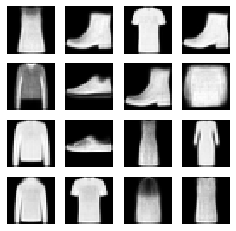

In [0]:
## Training VAE and plot reconstructed images

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for x in all_dataset:
    compute_apply_gradients(model, x, optimizer, latent_dim)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x, latent_dim))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    mu, sigma = model.encode(x)
    z = model.reparameterize(mu, sigma)

    generate_and_save_images(model, epoch, z[0:16])




We trained VAE with 4 latent dimensions using all samples in MNIST Fashion. Above are 16 reconstructed images. 

# Visualizing in 2-D Latent Space

In [0]:
# Train vae for 2d 
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
@tf.function
def compute_loss(model, x, latent_dim):
  q_mu, q_sigma = model.encode(x)
  q_z = tfp.distributions.Normal(loc=q_mu, scale=q_sigma) 
  p_z = tfp.distributions.Normal(loc=np.zeros(latent_dim, dtype=np.float32),scale=np.ones(latent_dim, dtype=np.float32))
  p_x_given_z_logits = model.decode(q_z.sample())
  p_x_given_z = tfp.distributions.Bernoulli(logits=p_x_given_z_logits) 
  kl = tf.reduce_sum(tfp.distributions.kl_divergence(q_z, p_z), 1)
  expected_log_likelihood = tf.reduce_sum(p_x_given_z.log_prob(x),[1, 2, 3])
  elbo = tf.reduce_mean(expected_log_likelihood - kl, 0)
  return -elbo 

@tf.function
def compute_apply_gradients(model, x, optimizer, latent_dim):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, latent_dim)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

epochs = 10
latent_dim = 2
model = CVAE(latent_dim)

for epoch in range(1, epochs + 1):
  for x in all_dataset:
    compute_apply_gradients(model, x, optimizer, latent_dim)




In [0]:
# preparing for visualization
mu, sigma = model.encode(train_images[:5000])
z = model.reparameterize(mu, sigma)
data = np.column_stack((z, train_labels[:5000]))
df = pd.DataFrame(data)
df[2] = df[2].astype('str')
label_des = {'0.0':'T-shirt/top', '1.0':'Trouser', '2.0':	'Pullover', '3.0':'Dress', '4.0':'Coat','5.0':'Sandal','6.0':'Shirt', '7.0':'Sneaker',
'8.0':'Bag', '9.0':'Ankle boot'}
df.columns = ['x', 'y', 'label']
df['label'] = df['label'].map(label_des)

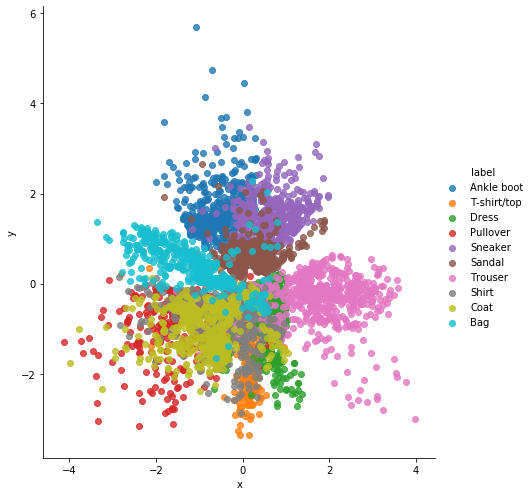

In [0]:
sns_plot = sns.lmplot( x='x', y='y', data=df, fit_reg=False, hue='label', legend=True, height=7, aspect=0.9)
sns_plot.savefig('2D.png')

Above is a scatter plot for 5000 training samples using VAE with latent dimension 2. Note that with only 2 dimensions, the clusters have severe overlaps between "pullover" and "coat", "t-shirt/top" and "shirt". 

# Images for different latent dim

We generate reconstructed images for different latent dimensions to check if VAE performs well.

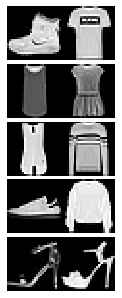

In [0]:
## Orignial
fig = plt.figure()
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.axis('off')
    plt.imshow(train_images[i, :, :, 0], cmap='gray')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=0.25, bottom=0, top=1)
plt.show()
fig.savefig('Original',bbox_inches='tight')


In [0]:
## Dim: 2, 4, 25
dim = [2, 4, 25]
for d in dim:
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
  @tf.function
  def compute_loss(model, x, latent_dim):
    q_mu, q_sigma = model.encode(x)
    q_z = tfp.distributions.Normal(loc=q_mu, scale=q_sigma) 
    p_z = tfp.distributions.Normal(loc=np.zeros(latent_dim, dtype=np.float32),scale=np.ones(latent_dim, dtype=np.float32))
    p_x_given_z_logits = model.decode(q_z.sample())
    p_x_given_z = tfp.distributions.Bernoulli(logits=p_x_given_z_logits) 
    kl = tf.reduce_sum(tfp.distributions.kl_divergence(q_z, p_z), 1)
    expected_log_likelihood = tf.reduce_sum(p_x_given_z.log_prob(x),[1, 2, 3])
    elbo = tf.reduce_mean(expected_log_likelihood - kl, 0)
    return -elbo 

  @tf.function
  def compute_apply_gradients(model, x, optimizer, latent_dim):
    with tf.GradientTape() as tape:
      loss = compute_loss(model, x, latent_dim)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  epochs = 10
  latent_dim = d
  model = CVAE(latent_dim)

  for epoch in range(1, epochs + 1):
    for x in all_dataset:
      compute_apply_gradients(model, x, optimizer, latent_dim)

  mu, sigma = model.encode(train_images[0:16])
  z = model.reparameterize(mu, sigma)
  reconstructed_images = model.decode(z, apply_sigmoid=True)

  fig = plt.figure()
  for i in range(10):
    plt.subplot(5,2,i+1)
    plt.axis('off')
    plt.imshow(reconstructed_images[i, :, :, 0], cmap='gray')
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=0.25, bottom=0, top=1)
  plt.show()
  fig.savefig('dim_' + str(d), bbox_inches='tight')


The first 10 reconstructed images are shown below. We can see that with only 2 latent dimensions, the sneaker in (row 1, col 1) looks like an ankle boot, and the dress in (row 2, col 2) looks like T-shirt. Hence, dimension 2 is not sufficient. Reconstructed images with higher latent dimensions like 4 and 25 become more distinguishable. However, they are sill not able to capture the details for clothing, such as logos and stripes, which indicates VAE may be good for classification but it is not a powerful generative model.

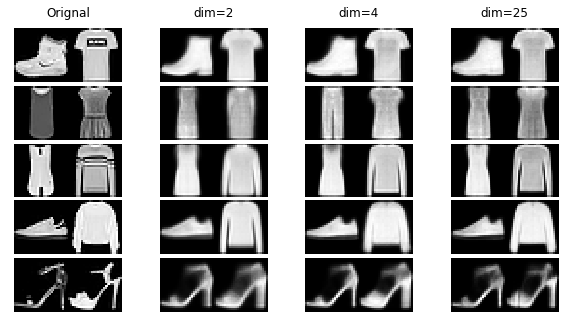

In [0]:
# Orignal images and Reconstructed images for dim 2, 4, 25
fig = plt.figure(figsize=(10,10))
img1=mpimg.imread('Original.png')
img2=mpimg.imread('dim_2.png')
img3=mpimg.imread('dim_4.png')
img4=mpimg.imread('dim_25.png')
img = [img1, img2, img3, img4]
t = ['Orignal', 'dim=2', 'dim=4', 'dim=25']

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.title(t[i])
    plt.imshow(img[i])
fig.savefig('img_all', bbox_inches='tight')

# Latent Dimension Choosing 

The reconstructed images above show that 4 seems to be a good choice for latent dimension of VAE. We verify this by tuning the latent dimension and comparing the classification test accuracy. Note here we only used 100 samples to train our classifiers because we expect VAE may be superior in small dimensions. 

In [0]:
dim = [4, 9, 16, 25]
logistic_accuracy = np.zeros(4)
cnn_accuracy = np.zeros(4)
for i in range(len(dim)):
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
  @tf.function
  def compute_loss(model, x, latent_dim):
    q_mu, q_sigma = model.encode(x)
    q_z = tfp.distributions.Normal(loc=q_mu, scale=q_sigma) 
    p_z = tfp.distributions.Normal(loc=np.zeros(latent_dim, dtype=np.float32),scale=np.ones(latent_dim, dtype=np.float32))
    p_x_given_z_logits = model.decode(q_z.sample())
    p_x_given_z = tfp.distributions.Bernoulli(logits=p_x_given_z_logits) 
    kl = tf.reduce_sum(tfp.distributions.kl_divergence(q_z, p_z), 1)
    expected_log_likelihood = tf.reduce_sum(p_x_given_z.log_prob(x),[1, 2, 3])
    elbo = tf.reduce_mean(expected_log_likelihood - kl, 0)
    return -elbo 

  @tf.function
  def compute_apply_gradients(model, x, optimizer, latent_dim):
    with tf.GradientTape() as tape:
      loss = compute_loss(model, x, latent_dim)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  epochs = 10
  latent_dim = dim[i]
  model = CVAE(latent_dim)

  for epoch in range(1, epochs + 1):
    for x in all_dataset:
      compute_apply_gradients(model, x, optimizer, latent_dim)
  
  ##using vae to get latent variable z (training)
  mu, sigma = model.encode(train_images[:100])
  z_latent = model.reparameterize(mu, sigma)

  ## get the latent variables for test_images
  mu, sigma = model.encode(test_images)
  test_latent = model.reparameterize(mu, sigma)
 
  ## feed z into classifiers to do classification
  ### logistic:
  logistic = tf.keras.Sequential([
     tf.keras.layers.InputLayer(input_shape=(latent_dim)),
     # softmax of x is calculated by exp(x)/tf.reduce_sum(exp(x)).
     tf.keras.layers.Dense(10, activation='softmax'),
    ])
  
  logistic.compile(optimizer='sgd',
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])
  logistic.fit(z_latent, train_labels[:100], epochs=300, verbose=0) 
  logistic_accuracy[i] = logistic.evaluate(test_latent, test_labels, verbose = 0 )[1]
  
  ### cnn:
  # reshape z 
  reshape_dim1 = int(np.sqrt(latent_dim))
  reshape_dim2 = int(np.sqrt(latent_dim))
  z_2= tf.reshape(z_latent, [z_latent.shape[0], reshape_dim1, reshape_dim2, 1])
  ## reshape test
  test_latent_reshaped=tf.reshape(test_latent, [test_latent.shape[0], reshape_dim1, reshape_dim2, 1])

  cnn_model = tf.keras.Sequential([
                tf.keras.layers.InputLayer(input_shape=(reshape_dim1, reshape_dim2, 1)),
                 # one convolution layer
               tf.keras.layers.Conv2D(filters=1024, kernel_size=2, strides=2, activation='relu'),
              # fully connected
              tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(10, activation='softmax')
  ])

  cnn_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy']
                )
  cnn_model.fit(z_2, train_labels[:100], epochs=150, verbose=0) 
  cnn_accuracy[i] = cnn_model.evaluate(test_latent_reshaped, test_labels, verbose = 0 )[1]
  #print("latent_dim " + str(dim[i]) + ": ", logistic_accuracy[i], cnn_accuracy[i])

In [0]:
  data = {'Latent_dimension' : dim, 'Logistic_accuracy':logistic_accuracy, 'cnn_accuracy': cnn_accuracy}
  latent_dim_table = pd.DataFrame(data)
  latent_dim_table
  

,Latent_dimension,Logistic_accuracy,cnn_accuracy
0,4,0.5744,0.6389
1,9,0.5428,0.5336
2,16,0.5009,0.5257
3,25,0.3853,0.1998


Table above shows that as the latent dimension increases, the test accuracy for both logistics and CNN decreases. Thus, dimension 4 is already sufficient for both image reconstruction and classification, which is a big compression of data.

# Accuracy vs training samples

We kept our trained 4 latent dimension VAE fixed, and obtained latent variables from VAE. We used these latent variables as inputs for logistic regression and simple CNN. We also implemented a multilayer CNN using orignial data. We then compared the classification results for small and large samples for these three methods, i.e. VAE + logistic regression, VAE + simple CNN, and multilayer CNN.

In [0]:

def acc_samples(sample_num, classifier='simple cnn'):
    # random shuffle the data to get a sample of training data
    idxs = tf.range(tf.shape(train_images)[0])
    ridxs = tf.random.shuffle(idxs)[:sample_num]
    train_images_sub = tf.gather(train_images, ridxs)
    train_labels_sub = tf.gather(train_labels, ridxs)

    mu, sigma = model.encode(train_images_sub)
    z_latent = model.reparameterize(mu, sigma)

    mu_test, sigma_test = model.encode(test_images)
    test_latent = model.reparameterize(mu_test, sigma_test)


    if classifier == 'logistic':
        logistic = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim)),
            # softmax of x is calculated by exp(x)/tf.reduce_sum(exp(x)).
            tf.keras.layers.Dense(10, activation='softmax'),
            ])

        # model compile 
        logistic.compile(optimizer='sgd',
                    loss='sparse_categorical_crossentropy',
                    metrics=['sparse_categorical_accuracy']
                    )
        
        history = logistic.fit(z_latent, train_labels_sub, epochs=300, verbose=0)
        training_acc = history.history['sparse_categorical_accuracy'][-1]

        loss, test_acc = logistic.evaluate(test_latent, test_labels, verbose=0)

    elif classifier == 'simple cnn':
        reshape_dim1 = reshape_dim2 = 2
        z_2 = tf.reshape(z_latent, [z_latent.shape[0], reshape_dim1, reshape_dim2, 1])
        cnn_model = tf.keras.Sequential([
                tf.keras.layers.InputLayer(input_shape=(reshape_dim1, reshape_dim2, 1)),
                # one convolution layer
                tf.keras.layers.Conv2D(filters=1024, kernel_size=2, strides=2, activation='relu'),
                # fully connected
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(10, activation='softmax')
        ])

        # model compile 
        cnn_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['sparse_categorical_accuracy']
                    )
        
        history = cnn_model.fit(z_2, train_labels_sub, epochs=150, verbose=0) 
        training_acc = history.history['sparse_categorical_accuracy'][-1]

        test_latent=tf.reshape(test_latent, [test_latent.shape[0], reshape_dim1, reshape_dim2, 1])
        loss, test_acc = cnn_model.evaluate(test_latent, test_labels, verbose=0)

    elif classifier == 'multi-layer cnn':
        model_3 = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(64, (5, 5), padding = 'same', activation='relu'),   
            tf.keras.layers.MaxPooling2D((2, 2)),  
            tf.keras.layers.Conv2D(32, (3, 3), padding = 'same', activation='relu'),  
            tf.keras.layers.MaxPooling2D((2, 2)),  
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(10, activation='softmax')
        ])

        model_3.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['sparse_categorical_accuracy']
                        )
        
        history = model_3.fit(train_images_sub, train_labels_sub, batch_size=100, epochs=100, verbose=0) 
        training_acc = history.history['sparse_categorical_accuracy'][-1]

        loss, test_acc = model_3.evaluate(test_images, test_labels, verbose=0)
        
    else:
        raise ValueError('Invalid input!')
    
    return test_acc

In [0]:
sample_num_ls = [100, 1000, 2000, 5000, 10000, 20000, 50000]
# sample_num_ls = [100]
models_ls= ['logistic', 'simple cnn', 'multi-layer cnn']

In [0]:
res = [[0 for i in range(len(models_ls))] for j in range(len(sample_num_ls))]

for i in range(len(models_ls)):
    candidate = models_ls[i]
    for j in range(len(sample_num_ls)):
        sample_num = sample_num_ls[j]
        res[j][i] = acc_samples(sample_num, classifier=candidate)


In [0]:
test_acc = [*zip(*res)]

acc_samples = pd.DataFrame({
    'Num of Training Samples':sample_num_ls,
    'VAE+logistic': test_acc[:][0],
    'VAE+CNN': test_acc[:][1],
    'Multi-layer CNN': test_acc[:][2]
})
acc_samples_table = pd.DataFrame(acc_samples)
acc_samples_table

,Num of Training Samples,VAE+logistic,VAE+CNN,Multi-layer CNN
0,100,0.5805,0.6382,0.6950
1,1000,0.6999,0.7678,0.8348
2,2000,0.7042,0.7914,0.8482
3,5000,0.7165,0.7876,0.8683
4,10000,0.7170,0.7987,0.8876
5,20000,0.7189,0.8030,0.9036
6,50000,0.7174,0.8091,0.9191


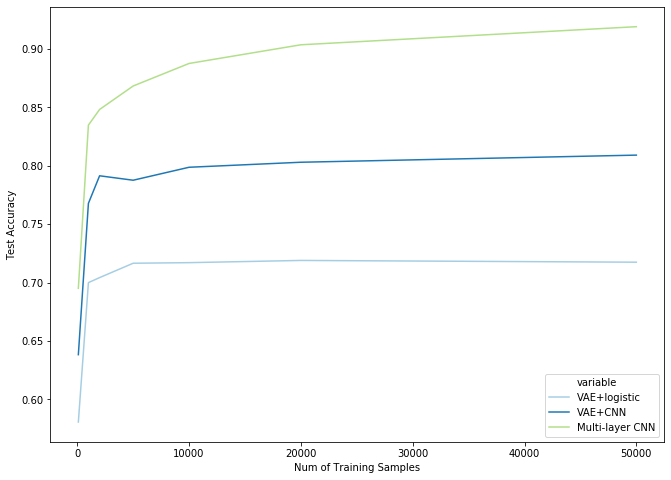

In [0]:
with sns.color_palette("Paired"):
    fig, ax = plt.subplots()
    fig.set_size_inches(11, 8)
    line_plot=sns.lineplot(x='Num of Training Samples', y='value',hue='variable', 
                 markers='o', data=pd.melt(acc_samples, ['Num of Training Samples']))
    ax.set(ylabel='Test Accuracy')
    plt.show()


From the table above we can see VAE + simple CNN performs better than VAE + logistic regression. Multi-layer CNN always performs the best. However, for small samples, training accuracy and test accuracy for VAE + logistic is quite close for small number of epochs, which means overfitting problem is mitigated by VAE. For VAE+CNN and multi-layer CNN, training and test accuracy have huge differences, sometimes as high as 20%. It is reason-able overfitting phenomena because for small training samples like 100 or 1000,number of parameters of CNN model is far more than number of samples.

# Conclusion

Variational Auto-Encoder is a cool idea based on Bayesian. It uses latent variables to represent image data by neural network. We can infer easily what kind of fashion product is in our reconstructed images, which means VAE does explain much variation of original images. For our encoder and decoder, 4 latent variables are sufficient to get satisfying accuracy for afterward classification which is a huge dimension reduction (from 28*28 = 784 to 4). 

Random guess accuracy for fashion-mnist data is 10\%. With only 100 samples, the test accuracy of VAE + logisitc regression can reach 53.4\%, and VAE + simple CNN can reach 66.2\%. With 50,000 training samples, VAE + simple CNN can reach 81.4\% accuracy.

Unfortunately, VAEs do have limitations. Obviously they are not quite the state-of-the-art in generative models (blurry reconstructed images). Besides, the accuracy for downstream classification still cannot compare with multi-layer CNN no matter for small samples or large samples. Though logistic regression benefits from the reduction of input dimensions with consistent training and test accuracy, its accuracy is still lower than those using CNN.